# Treebank NER with Bi-LSTM-CRF on morphemes

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [6]:
from conlleval import evaluate

In [7]:
from ner_utils import *

Using TensorFlow backend.


## Get morpheme data

In [8]:
yap_dev = pd.read_csv('new_yap_outputs/yap_dev.csv.gz', compression='gzip')
yap_test = pd.read_csv('new_yap_outputs/yap_test.csv.gz', compression='gzip')

In [9]:
dropped = [5438, 5444, 5445, 5446, 5448, 5449, 5450, 5451, 5453, 5459]

In [10]:
spdf = pd.read_csv('align/spdf_fixed.csv.gz', compression='gzip')
spdf = spdf[(~spdf.sent_id.isin(dropped))]

In [11]:
spdf.head()

,id,form,lemma,upostag,xpostag,feats,token_id,sent_id,token_str,global_sent_id,...,binyan,biose,ner_layers,ner,head,deprel,deps,misc,ner_escaped,set
0,1,עשרות,עשר,CDT,CDT,gen=F|num=P,1,1,עשרות,1,...,---,O,0,_,2,num,_,_,_,dev
1,2,אנשים,איש,NN,NN,gen=M|num=P,2,1,אנשים,1,...,---,O,0,_,3,subj,_,_,_,dev
2,3,מגיעים,הגיע,BN,BN,gen=M|num=P|per=A|HebBinyan=HIFIL,3,1,מגיעים,1,...,HIFIL,O,0,_,0,ROOT,_,_,_,dev
3,4,מ,מ,PREPOSITION,PREPOSITION,_,4,1,מתאילנד,1,...,---,O,0,_,3,prepmod,_,_,_,dev
4,5,תאילנד,תאילנד,NNP,NNP,_,4,1,מתאילנד,1,...,---,S-GPE,1,GPE,4,pobj,_,_,GPE,dev


In [12]:
yap_dev.head()

,id,form,lemma,upostag,xpostag,head,deprel,deps,misc,sent,misc_token_id,misc_token_str,feats_gen,feats_num,feats_per,feats_tense,feats_suf_gen,feats_suf_num,feats_suf_per,sent_id
0,1,עשרות,עשר,CDT,CDT,2,num,_,_,1,1,עשרות,F,P,NaN,NaN,NaN,NaN,NaN,1
1,2,אנשים,איש,NN,NN,3,subj,_,_,1,2,אנשים,M,P,NaN,NaN,NaN,NaN,NaN,1
2,3,מגיעים,הגיע,BN,BN,14,conj,_,_,1,3,מגיעים,M,P,A,NaN,NaN,NaN,NaN,1
3,4,מ,מ,PREPOSITION,PREPOSITION,3,comp,_,_,1,4,מתאילנד,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,5,תאילנד,תאילנד,NNP,NNP,4,pobj,_,_,1,4,מתאילנד,F,S,NaN,NaN,NaN,NaN,NaN,1


In [13]:
yap_dev_sents =  yap_dev.groupby('sent_id')[['form', 'upostag']].apply(lambda x: x.values.tolist())
yap_dev_sents.head()

sent_id
1    [[עשרות, CDT], [אנשים, NN], [מגיעים, BN], [מ, ...
2    [[תופעה, NN], [זו, PRP], [התבררה, VB], [אתמול,...
3    [[יו"ר, NNT], [ה, DEF], [וועדה, NN], [,, yyCM]...
4    [[מ, PREPOSITION], [צד, NN], [אחד, CD], [רוצה,...
5    [[נמיר, NNP], [הודיעה, VB], [כי, CC], [תפנה, V...
dtype: object

In [14]:
yap_test_sents =  yap_test.groupby('sent_id')[['form', 'upostag']].apply(lambda x: x.values.tolist())
yap_test_sents.head()

sent_id
5439    [[ה, DEF], [כל, DTT], [נושאים, NN], [עמם, VB],...
5440    [[אומר, NNT], [מזכיר, NNT], [ה, DEF], [תק"ם, N...
5441    [[לא, RB], [ייתכן, MD], [ש, REL], [עולה, NN], ...
5442    [[לא, RB], [ייתכן, MD], [ש, REL], [הוא, PRP], ...
5443    [[לכן, CC], [קבענו, VB], [עיקרון, NN], [ש, REL...
dtype: object

In [15]:
gold_dev  = spdf[spdf.set=='dev']
gold_train = spdf[spdf.set=='train']
gold_test = spdf[spdf.set=='test']

In [16]:
gold_dev_sents = gold_dev.groupby('sent_id')[['form', 'upostag', 'biose']].apply(lambda x: x.values.tolist())
gold_train_sents = gold_train.groupby('sent_id')[['form', 'upostag', 'biose']].apply(lambda x: x.values.tolist())
gold_test_sents = gold_test.groupby('sent_id')[['form', 'upostag', 'biose']].apply(lambda x: x.values.tolist())
gold_test_sents.head()

sent_id
5439    [[הכל, NN, O], [נושאים, BN, O], [עמ, IN, O], [...
5440    [[אומר, BN, O], [מזכיר, NNT, O], [התק"ם, NNP, ...
5441    [[לא, RB, O], [ייתכן, MD, O], [ש, REL, O], [עו...
5442    [[לא, RB, O], [ייתכן, MD, O], [ש, REL, O], [הו...
5443    [[לכן, CC, O], [קבענו, VB, O], [עיקרון, NN, O]...
dtype: object

In [17]:
words = list(set(spdf.form.values)|set(yap_dev.form.values)|set(yap_test.form.values))
n_words = len(words); n_words

18465

In [18]:
tags = list(set(spdf.biose.values))
n_tags = len(tags); n_tags

37

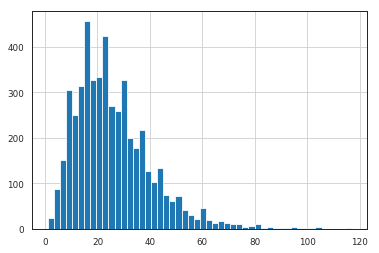

In [19]:
gold_train.groupby('sent_id').size().hist(bins=50)

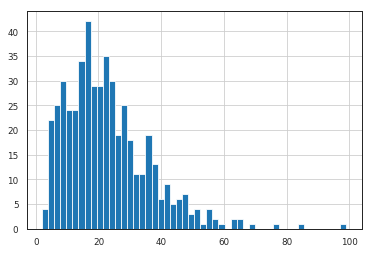

In [20]:
yap_dev.groupby('sent_id').size().hist(bins=50)

In [21]:
max_len = 80
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [22]:
from keras.preprocessing.sequence import pad_sequences
X_gold_train = [[word2idx[w[0]] for w in s] for s in gold_train_sents]
X_gold_dev   = [[word2idx[w[0]] for w in s] for s in gold_dev_sents]
X_gold_test  = [[word2idx[w[0]] for w in s] for s in gold_test_sents]
X_yap_dev    = [[word2idx[w[0]] for w in s] for s in yap_dev_sents]
X_yap_test   = [[word2idx[w[0]] for w in s] for s in yap_test_sents]

In [23]:
X_gold_train = pad_sequences(maxlen=max_len, sequences=X_gold_train, value=word2idx["PAD"], padding='post', truncating='post')
X_gold_dev   = pad_sequences(maxlen=max_len, sequences=X_gold_dev  , value=word2idx["PAD"], padding='post', truncating='post')
X_gold_test  = pad_sequences(maxlen=max_len, sequences=X_gold_test , value=word2idx["PAD"], padding='post', truncating='post')
X_yap_dev    = pad_sequences(maxlen=max_len, sequences=X_yap_dev   , value=word2idx["PAD"], padding='post', truncating='post')
X_yap_test   = pad_sequences(maxlen=max_len, sequences=X_yap_test  , value=word2idx["PAD"], padding='post', truncating='post')
X_gold_train[0]

array([16890, 17274,    24,  5921, 15000,  5225,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [24]:
pos = list(set(spdf.upostag.values)|set(yap_dev.upostag.values)|set(yap_test.upostag.values))
n_pos = len(pos); n_pos

52

In [25]:
pos2idx = {w: i+1 for i, w in enumerate(pos)}
pos2idx["PAD"] = 0

In [26]:
from keras.preprocessing.sequence import pad_sequences
X_pos_gold_train = [[pos2idx[w[1]] for w in s] for s in gold_train_sents]
X_pos_gold_dev   = [[pos2idx[w[1]] for w in s] for s in gold_dev_sents]
X_pos_gold_test  = [[pos2idx[w[1]] for w in s] for s in gold_test_sents]
X_pos_yap_dev    = [[pos2idx[w[1]] for w in s] for s in yap_dev_sents]
X_pos_yap_test   = [[pos2idx[w[1]] for w in s] for s in yap_test_sents]

In [27]:
X_pos_gold_train = pad_sequences(maxlen=max_len, sequences=X_pos_gold_train, value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_gold_dev   = pad_sequences(maxlen=max_len, sequences=X_pos_gold_dev  , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_gold_test  = pad_sequences(maxlen=max_len, sequences=X_pos_gold_test , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_yap_dev    = pad_sequences(maxlen=max_len, sequences=X_pos_yap_dev   , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_yap_test   = pad_sequences(maxlen=max_len, sequences=X_pos_yap_test  , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_gold_train[0]

array([32, 19, 11, 30, 44, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [28]:
from keras.preprocessing.sequence import pad_sequences
y_gold_train = [[tag2idx[w[2]] for w in s] for s in gold_train_sents]
y_gold_dev   = [[tag2idx[w[2]] for w in s] for s in gold_dev_sents]
y_gold_test  = [[tag2idx[w[2]] for w in s] for s in gold_test_sents]

In [29]:
y_numer_gold_train = pad_sequences(maxlen=max_len, sequences=y_gold_train, value=pos2idx["PAD"], padding='post', truncating='post')
y_numer_gold_dev   = pad_sequences(maxlen=max_len, sequences=y_gold_dev  , value=pos2idx["PAD"], padding='post', truncating='post')
y_numer_gold_test  = pad_sequences(maxlen=max_len, sequences=y_gold_test , value=pos2idx["PAD"], padding='post', truncating='post')
y_numer_gold_train[0]

array([14, 14, 14, 14, 14, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [30]:
from keras.utils import to_categorical
y_gold_train = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_gold_train]
y_gold_dev   = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_gold_dev  ]
y_gold_test  = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_gold_test ]

y_gold_train[0].shape

(80, 38)

In [31]:
validation_split = len(X_gold_dev) / (len(X_gold_train)+len(X_gold_dev))
validation_split

0.09196247930844216

In [32]:
splits = [[X_gold_train, X_gold_dev,
           y_gold_train, y_gold_dev,
           X_pos_gold_train, X_pos_gold_dev ]]

### Prep char input

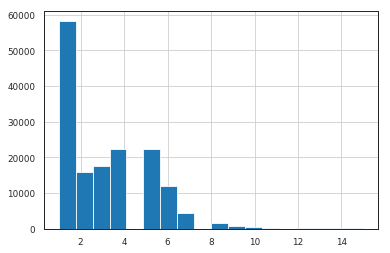

In [33]:
spdf.form.apply(len).hist(bins=18)

In [34]:
max_len_char = 12

In [35]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

50


In [36]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [37]:

def get_X_char(sents):
    X_char = []
    for sentence in sents:
        sent_seq = []
        for i in range(max_len):
            word_seq = []
            for j in range(max_len_char):
                try:
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                except:
                    word_seq.append(char2idx.get("PAD"))
            sent_seq.append(word_seq)
        X_char.append(np.array(sent_seq))
    return X_char

In [38]:
X_char_gold_dev   = get_X_char(gold_dev_sents  )
X_char_gold_train = get_X_char(gold_train_sents)
X_char_gold_test  = get_X_char(gold_test_sents )
X_char_yap_dev    = get_X_char(yap_dev_sents   )
X_char_yap_test   = get_X_char(yap_test_sents  )



splits_char = [[X_char_gold_train, X_char_gold_dev,
                y_gold_train, y_gold_dev]]

## Embeddings

In [39]:
embedding_paths

{'yap_w2v_sg': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_skipgram.txt',
 'yap_w2v_cbow': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_cbow.txt',
 'yap_glove': '../wordembedding-hebrew/glove/wikipedia.yap_form.glove.txt.txt',
 'yap_ft_sg': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_skipgram.model.vec',
 'yap_ft_cbow': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_cbow.model.vec',
 'token_w2v_sg': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_skipgram.txt',
 'token_w2v_cbow': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_cbow.txt',
 'token_glove': '../wordembedding-hebrew/glove/wikipedia.tokenized.glove.txt',
 'token_ft_sg': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_skipgram.model.vec',
 'token_ft_cbow': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_cbow.model.vec',
 'pretrained_token_ft': '../fasttext/wiki.he.vec'}

In [40]:
exclude = ['cbow', 'word2vec', 'tokenized', 'glove']

In [41]:
embedding_mats = {}
for emb_name, emb_path in embedding_paths.items():
    skip=False
    for exc in exclude:
        if exc in emb_path:
            skip=True
    if skip:
        continue
    embedding_mats[emb_name] = get_embedding_matrix(emb_path, word2idx)

loading word embeddings: ../wordembedding-hebrew/wikipedia.yap_form.fasttext_skipgram.model.vec
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 1457
sample words not found:  ['מנצסטר' 'התרשמנו' 'אנוטוניוס' '4054' 'טארפלי' 'יצנטה' 'מנהאטן' 'אחה"ץ'
 'יישותי' 'הצטנע']
loading word embeddings: ../fasttext/wiki.he.vec
found 488194 word vectors
preparing embedding matrix...
number of null word embeddings: 1704
sample words not found:  ['685' 'פאמאליקאו' 'סקאיף' '2.2' 'מרנשטיין' '201' 'עקילוב' 'לויאן'
 'ישקיפו' 'ימק"א']


## Model building

In [42]:
configs = build_configs(base_configs, embedding_mats)
configs     

[{'crf': True, 'use_pos': False},
 {'crf': True, 'use_pos': True},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'pretrained_token_ft',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': True,
  'embedding_matrix': 'yap_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': True,
  'embedding_matrix': 'pretrained_token_ft',
  'trainable': True,
  'embed_dim': 300},
 {'use_char': True, 'crf': True, 'use_pos': False},
 {'use_char': True, 'crf': True, 'use_pos': True},
 {'add_random_embedding': False,
  'use_char': True,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'use_char': True,
  'crf': True,

In [43]:
for conf in configs:
    conf['patience'] = 10

In [44]:
out_folder = 'results/new_outputs'
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [45]:
extra_preds = [(X_gold_test, X_pos_gold_test, X_char_gold_test), 
               (X_yap_dev, X_pos_yap_dev, X_char_yap_dev),
               (X_yap_test, X_pos_yap_test, X_char_yap_test)]

In [46]:
from ner_utils import *

Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 57s - loss: 0.3738 - crf_accuracy: 0.9262 - val_loss: 0.1986 - val_crf_accuracy: 0.9621
Epoch 2/100
 - 49s - loss: 0.1267 - crf_accuracy: 0.9721 - val_loss: 0.1442 - val_crf_accuracy: 0.9665
Epoch 3/100
 - 47s - loss: 0.0909 - crf_accuracy: 0.9762 - val_loss: 0.1269 - val_crf_accuracy: 0.9669
Epoch 4/100
 - 51s - loss: 0.0643 - crf_accuracy: 0.9814 - val_loss: 0.1103 - val_crf_accuracy: 0.9709
Epoch 5/100
 - 48s - loss: 0.0453 - crf_accuracy: 0.9852 - val_loss: 0.0853 - val_crf_accuracy: 0.9727
Epoch 6/100
 - 47s - loss: 0.0330 - crf_accuracy: 0.9877 - val_loss: 0.1063 - val_crf_accuracy: 0.9716
Epoch 7/100
 - 54s - loss: 0.0234 - crf_accuracy: 0.9894 - val_loss: 0.0967 - val_crf_accuracy: 0.9732
Epoch 8/100
 - 50s - loss: 0.0149 - crf_accuracy: 0.9913 - val_loss: 0.0738 - val_crf_accuracy: 0.9748
Epoch 9/100
 - 49s - loss: 0.0084 - crf_accuracy: 0.9924 - val_loss: 0.0702 - val_crf_accuracy: 0.9744
Epoch 10/100
 - 53s - loss

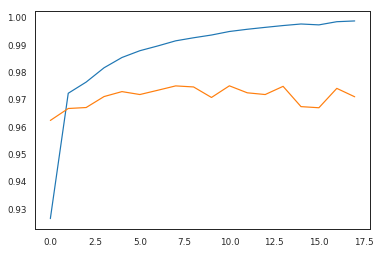

processed 11278 tokens with 498 phrases; found: 326 phrases; correct: 184.
accuracy:  35.09%; (non-O)
accuracy:  93.30%; precision:  56.44%; recall:  36.95%; FB1:  44.66
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
              GPE: precision:  77.53%; recall:  57.50%; FB1:  66.03  89
              LOC: precision:  21.05%; recall:  14.29%; FB1:  17.02  19
              ORG: precision:  45.83%; recall:  27.73%; FB1:  34.55  72
              PER: precision:  54.17%; recall:  40.41%; FB1:  46.29  144
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 48s - loss: 0.3409 - crf_accuracy: 0.9332 - val_loss: 0.1836 - val_crf_accuracy: 0.9617
Epoch 2/100
 - 48s - loss: 0.1052 - 

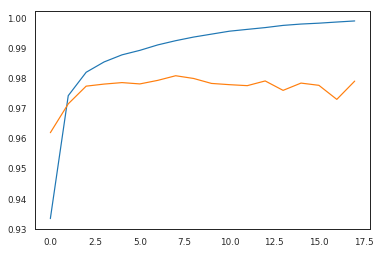

processed 11278 tokens with 498 phrases; found: 463 phrases; correct: 297.
accuracy:  54.27%; (non-O)
accuracy:  95.25%; precision:  64.15%; recall:  59.64%; FB1:  61.81
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              GPE: precision:  75.00%; recall:  65.00%; FB1:  69.64  104
              LOC: precision:  42.31%; recall:  39.29%; FB1:  40.74  26
              ORG: precision:  38.33%; recall:  38.66%; FB1:  38.49  120
              PER: precision:  76.42%; recall:  83.94%; FB1:  80.00  212
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 53s - loss: 0.2650 - crf_accuracy: 0.9481 - val_loss: 0.1259 - val_crf_accuracy: 0.9691
Epoch 2/100
 - 52s - loss: 0.0767 

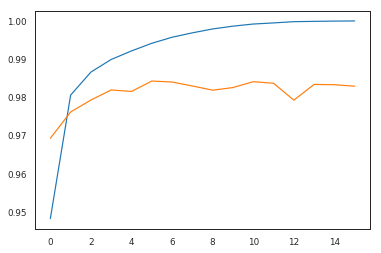

processed 11278 tokens with 498 phrases; found: 435 phrases; correct: 330.
accuracy:  61.23%; (non-O)
accuracy:  96.02%; precision:  75.86%; recall:  66.27%; FB1:  70.74
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              GPE: precision:  88.89%; recall:  80.00%; FB1:  84.21  108
              LOC: precision:  77.27%; recall:  60.71%; FB1:  68.00  22
              ORG: precision:  56.14%; recall:  53.78%; FB1:  54.94  114
              PER: precision:  80.85%; recall:  78.76%; FB1:  79.79  188
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 55s - loss: 0.2612 - crf_accuracy: 0.9412 - val_loss: 0.1114 - val_crf_accuracy: 0.9710
Epoch 2/100
 - 49s - loss: 0.0684 

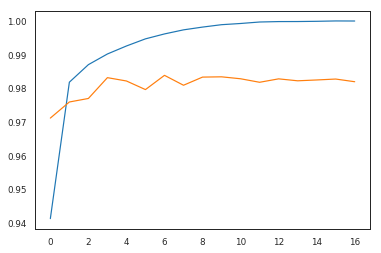

processed 11278 tokens with 498 phrases; found: 422 phrases; correct: 324.
accuracy:  62.43%; (non-O)
accuracy:  96.09%; precision:  76.78%; recall:  65.06%; FB1:  70.43
              ANG: precision: 100.00%; recall:  33.33%; FB1:  50.00  1
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              GPE: precision:  88.46%; recall:  76.67%; FB1:  82.14  104
              LOC: precision:  65.22%; recall:  53.57%; FB1:  58.82  23
              ORG: precision:  55.93%; recall:  55.46%; FB1:  55.70  118
              PER: precision:  86.71%; recall:  77.72%; FB1:  81.97  173
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 57s - loss: 0.2599 - crf_accuracy: 0.9515 - val_loss: 0.2419 - val_crf_accuracy: 0.9294
Epoch 2/100
 - 49s - loss: 0.0724 

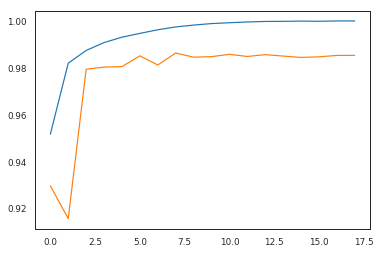

processed 11278 tokens with 498 phrases; found: 444 phrases; correct: 362.
accuracy:  66.10%; (non-O)
accuracy:  96.65%; precision:  81.53%; recall:  72.69%; FB1:  76.86
              ANG: precision: 100.00%; recall:  66.67%; FB1:  80.00  2
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:  50.00%; recall:   8.33%; FB1:  14.29  2
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  7
              GPE: precision:  92.52%; recall:  82.50%; FB1:  87.22  107
              LOC: precision:  45.16%; recall:  50.00%; FB1:  47.46  31
              ORG: precision:  70.87%; recall:  61.34%; FB1:  65.77  103
              PER: precision:  91.44%; recall:  88.60%; FB1:  90.00  187
              WOA: precision:  40.00%; recall:  22.22%; FB1:  28.57  5
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 56s - loss: 0.2694 - crf_accuracy: 0.9481 - val_loss: 0.1133 - val_crf_accuracy: 0.9696
Epoch 2/100
 - 52s - loss: 0.0654 

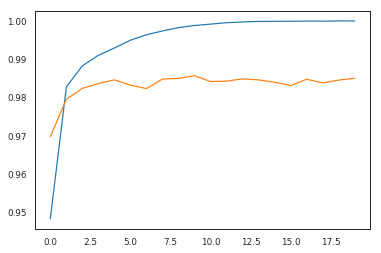

processed 11278 tokens with 498 phrases; found: 479 phrases; correct: 369.
accuracy:  67.20%; (non-O)
accuracy:  96.42%; precision:  77.04%; recall:  74.10%; FB1:  75.54
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:  33.33%; recall:   8.33%; FB1:  13.33  3
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              GPE: precision:  88.89%; recall:  80.00%; FB1:  84.21  108
              LOC: precision:  61.54%; recall:  57.14%; FB1:  59.26  26
              ORG: precision:  57.60%; recall:  60.50%; FB1:  59.02  125
              PER: precision:  85.78%; recall:  93.78%; FB1:  89.60  211
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 61s - loss: 0.3433 - crf_accuracy: 0.9313 - val_loss: 0.2254 - val_crf_accuracy: 0.9621
Epoch 2/100
 - 61s - loss: 0.1383 

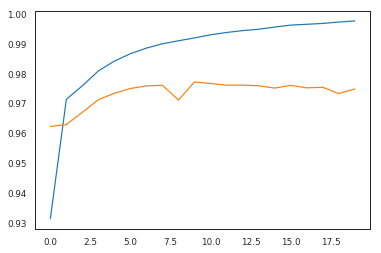

processed 11278 tokens with 498 phrases; found: 337 phrases; correct: 229.
accuracy:  43.74%; (non-O)
accuracy:  94.30%; precision:  67.95%; recall:  45.98%; FB1:  54.85
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
              GPE: precision:  76.84%; recall:  60.83%; FB1:  67.91  95
              LOC: precision:  57.89%; recall:  39.29%; FB1:  46.81  19
              ORG: precision:  56.16%; recall:  34.45%; FB1:  42.71  73
              PER: precision:  71.72%; recall:  53.89%; FB1:  61.54  145
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 63s - loss: 0.3317 - crf_accuracy: 0.9356 - val_loss: 0.1924 - val_crf_accuracy: 0.9622
Epoch 2/100
 - 55s - loss: 0.1143 - 

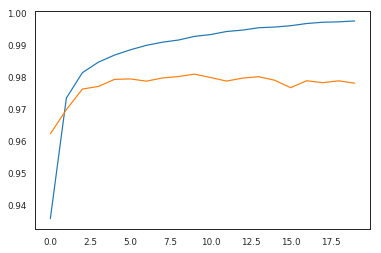

processed 11278 tokens with 498 phrases; found: 451 phrases; correct: 299.
accuracy:  54.67%; (non-O)
accuracy:  95.59%; precision:  66.30%; recall:  60.04%; FB1:  63.01
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
              GPE: precision:  83.70%; recall:  64.17%; FB1:  72.64  92
              LOC: precision:  48.00%; recall:  42.86%; FB1:  45.28  25
              ORG: precision:  39.46%; recall:  48.74%; FB1:  43.61  147
              PER: precision:  82.16%; recall:  78.76%; FB1:  80.42  185
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 67s - loss: 0.2680 - crf_accuracy: 0.9522 - val_loss: 0.1337 - val_crf_accuracy: 0.9677
Epoch 2/100
 - 56s - loss: 0.0857 -

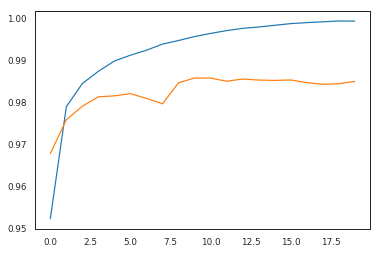

processed 11278 tokens with 498 phrases; found: 417 phrases; correct: 341.
accuracy:  63.92%; (non-O)
accuracy:  96.22%; precision:  81.77%; recall:  68.47%; FB1:  74.54
              ANG: precision: 100.00%; recall:  66.67%; FB1:  80.00  2
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:  16.67%; FB1:  28.57  2
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
              GPE: precision:  90.27%; recall:  85.00%; FB1:  87.55  113
              LOC: precision:  61.54%; recall:  57.14%; FB1:  59.26  26
              ORG: precision:  66.07%; recall:  62.18%; FB1:  64.07  112
              PER: precision:  91.77%; recall:  75.13%; FB1:  82.62  158
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 70s - loss: 0.2667 - crf_accuracy: 0.9477 - val_loss: 0.1247 - val_crf_accuracy: 0.9673
Epoch 2/100
 - 55s - loss: 0.0781 

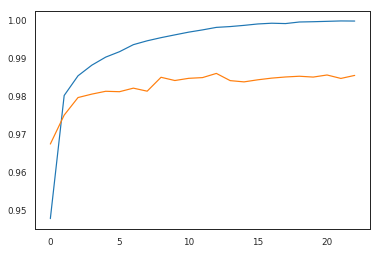

processed 11278 tokens with 498 phrases; found: 455 phrases; correct: 356.
accuracy:  66.60%; (non-O)
accuracy:  96.47%; precision:  78.24%; recall:  71.49%; FB1:  74.71
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
              GPE: precision:  83.05%; recall:  81.67%; FB1:  82.35  118
              LOC: precision:  62.96%; recall:  60.71%; FB1:  61.82  27
              ORG: precision:  66.33%; recall:  54.62%; FB1:  59.91  98
              PER: precision:  86.22%; recall:  87.56%; FB1:  86.89  196
              WOA: precision:  37.50%; recall:  33.33%; FB1:  35.29  8
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 70s - loss: 0.2573 - crf_accuracy: 0.9467 - val_loss: 0.1384 - val_crf_accuracy: 0.9658
Epoch 2/100
 - 57s - loss: 0.0753 -

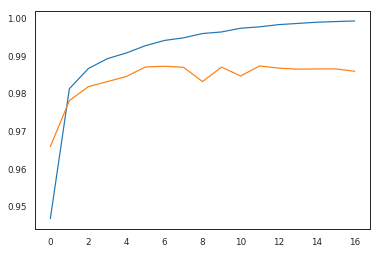

processed 11278 tokens with 498 phrases; found: 445 phrases; correct: 370.
accuracy:  66.70%; (non-O)
accuracy:  96.76%; precision:  83.15%; recall:  74.30%; FB1:  78.47
              ANG: precision: 100.00%; recall:  33.33%; FB1:  50.00  1
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:  16.67%; FB1:  28.57  2
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              GPE: precision:  89.92%; recall:  89.17%; FB1:  89.54  119
              LOC: precision:  66.67%; recall:  50.00%; FB1:  57.14  21
              ORG: precision:  69.79%; recall:  56.30%; FB1:  62.33  96
              PER: precision:  87.75%; recall:  92.75%; FB1:  90.18  204
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 69s - loss: 0.2583 - crf_accuracy: 0.9518 - val_loss: 0.1249 - val_crf_accuracy: 0.9679
Epoch 2/100
 - 58s - loss: 0.0762 -

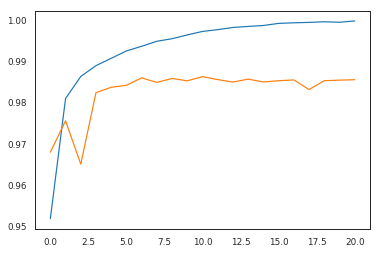

processed 11278 tokens with 498 phrases; found: 463 phrases; correct: 373.
accuracy:  66.60%; (non-O)
accuracy:  96.62%; precision:  80.56%; recall:  74.90%; FB1:  77.63
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:  16.67%; FB1:  28.57  2
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
              GPE: precision:  91.30%; recall:  87.50%; FB1:  89.36  115
              LOC: precision:  61.54%; recall:  57.14%; FB1:  59.26  26
              ORG: precision:  63.81%; recall:  56.30%; FB1:  59.82  105
              PER: precision:  88.18%; recall:  92.75%; FB1:  90.40  203
              WOA: precision:  14.29%; recall:  11.11%; FB1:  12.50  7


In [47]:
configs, results, preds, histories = run_models(configs, splits, splits_char, embedding_mats, 
                                                words, max_len, n_words, idx2word, idx2tag,
                                                n_tags, max_len_char, n_pos, n_chars,
                                                run_name='treebank_morphemes_fixed2', out_folder=out_folder,
                                                skip_if_model_exists=True,
                                                validation_split=validation_split,
                                                extra_predictions=extra_preds,
                                                )